# Stable Baselines3 Tutorial - Getting Started

Github repo: https://github.com/araffin/rl-tutorial-jnrr19

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a training framework for Reinforcement Learning (RL), using Stable Baselines3.

It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.

## Introduction

In this notebook, you will learn the basics for using stable baselines3 library: how to create a RL model, train it and evaluate it. Because all algorithms share the same interface, we will see how simple it is to switch from one algorithm to another.


## Install Dependencies and Stable Baselines3 Using Pip

List of full dependencies can be found in the [README](https://github.com/DLR-RM/stable-baselines3).


```
pip install stable-baselines3[extra]
```

In [1]:
# for autoformatting
# %load_ext jupyter_black

In [2]:
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [3]:
import stable_baselines3

print(f"{stable_baselines3.__version__=}")

stable_baselines3.__version__='2.5.0a0'


## Imports

Stable-Baselines works on environments that follow the [gym interface](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines.readthedocs.io/en/master/guide/algos.html)

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

print(f"{gym.__version__=}")

gym.__version__='1.0.0'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

In [5]:
from stable_baselines3 import PPO

The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor:

```PPO('MlpPolicy', env)``` instead of ```PPO(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy`, that's why using string for the policy is the recommened option.

In [6]:
from stable_baselines3.ppo import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gymnasium.farama.org/environments/classic_control/cart_pole/](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)

Note: vectorized environments allow to easily multiprocess training. In this example, we are using only one process, hence the DummyVecEnv.

We chose the MlpPolicy because input of CartPole is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space


Here we are using the [Proximal Policy Optimization](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) algorithm, which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


In [7]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
model = PPO(MlpPolicy, env, gamma=0.99, target_kl=0.3, ent_coef=0.5, verbose=0)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


We create a helper function to evaluate the agent:

In [8]:
def evaluate(model, env, num_episodes=500, deterministic=True):
    """
    Evaluate a RL agent and plot learning curve.

    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # vec_env = model.get_env()
    vec_env = env
    all_episode_rewards = []
    episode_lengths = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        episode_length = 0
        obs, _ = vec_env.reset()
        while not done:
            action, _states = model.predict(obs, deterministic=deterministic)
            # Use *_ to capture extra returned values, addressing the unpacking error
            obs, reward, done, info, *_ = vec_env.step(action)
            episode_rewards.append(reward)
            episode_length += 1

        all_episode_rewards.append(sum(episode_rewards))
        episode_lengths.append(episode_length)


    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    # Plot learning curve
    plt.plot(range(1, num_episodes + 1), all_episode_rewards)
    plt.fill_between(
        range(1, num_episodes + 1),
        np.array(all_episode_rewards) - std_episode_reward,
        np.array(all_episode_rewards) + std_episode_reward,
        alpha=0.2,
    )
    plt.xlabel("Episode Number")
    plt.ylabel("Episode Reward")
    plt.title("Learning Curve")
    plt.show()

    return mean_episode_reward, std_episode_reward, episode_lengths


def visualize_episode_lengths(episode_lengths):
    """
    Visualizes the distribution of episode lengths using a histogram.

    Args:
        episode_lengths: A list of episode lengths.
    """
    plt.hist(episode_lengths, bins=20)
    plt.xlabel("Episode Length")
    plt.ylabel("Frequency")
    plt.title("Distribution of Episode Lengths")
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In fact, Stable-Baselines3 already provides you with that helper:

In [9]:
# from stable_baselines3.common.evaluation import evaluate_policy

Let's evaluate the un-trained agent, this should be a random agent.

Mean reward: 9.376 Num episodes: 500


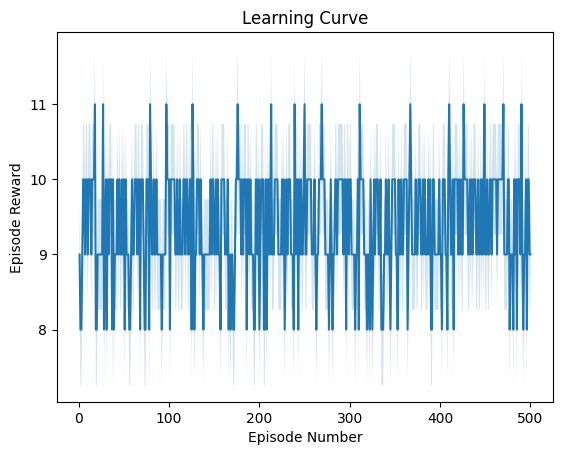

mean_reward:9.38 +/- 0.74


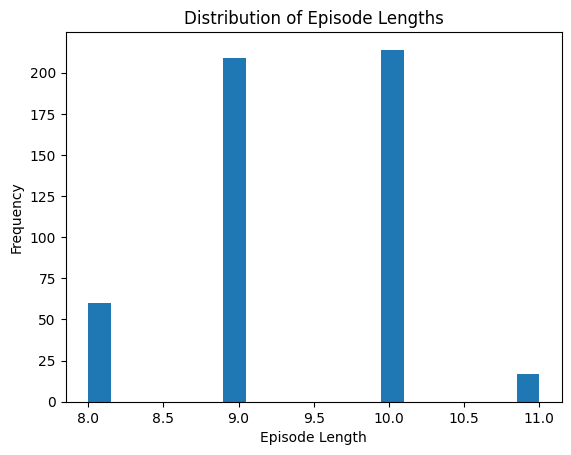

In [10]:
# Use a separate environement for evaluation
eval_env = gym.make("CartPole-v1", render_mode="rgb_array")

# Random Agent, before training
mean_reward, std_reward, episode_lengths = evaluate(model, eval_env, num_episodes=500)




print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

visualize_episode_lengths(episode_lengths)

## Train the agent and evaluate it

In [11]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10_000)

Mean reward: 542.476 Num episodes: 500


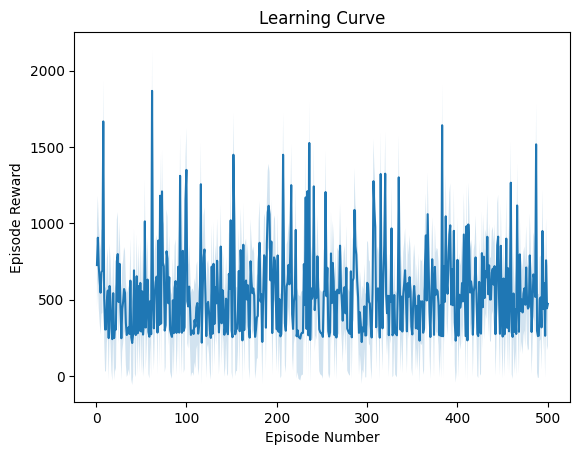

mean_reward:542.48 +/- 274.48


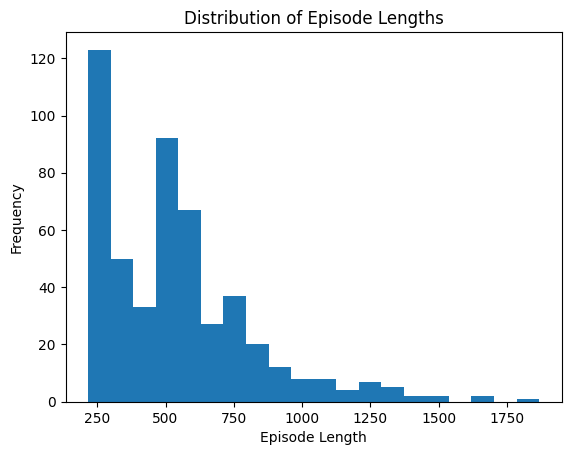

In [12]:
# Evaluate the trained agent
mean_reward, std_reward, episode_lengths = evaluate(model, eval_env, num_episodes=500)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
visualize_episode_lengths(episode_lengths)

Apparently the training went well, the mean reward increased a lot !

### Prepare video recording

In [13]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [14]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [15]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make("CartPole-v1", render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

### Visualize trained agent



In [ ]:
record_video("CartPole-v1", model, video_length=500, prefix="ppo-cartpole")

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Saving video to /content/videos/ppo-cartpole-step-0-to-step-500.mp4


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/ppo-cartpole-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/ppo-cartpole-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-cartpole-step-0-to-step-500.mp4


In [ ]:
show_videos("videos", prefix="ppo")

## Bonus: Train a RL Model in One Line

The policy class to use will be inferred and the environment will be automatically created. This works because both are [registered](https://stable-baselines.readthedocs.io/en/master/guide/quickstart.html).

In [ ]:
model = PPO('MlpPolicy', "CartPole-v1", verbose=1).learn(1000)

## Conclusion

In this notebook we have seen:
- how to define and train a RL model using stable baselines3, it takes only one line of code ;)
